In [23]:
import pandas as pd

# Load the data
bls_data = pd.read_csv('/Users/minhu/CS6190/final-project-3musketeers-AcutallyDone/data/BLS Data.csv')
cdc_data = pd.read_csv('/Users/minhu/CS6190/final-project-3musketeers-AcutallyDone/data/CDC Data.csv')
utah_data = pd.read_csv('/Users/minhu/CS6190/final-project-3musketeers-AcutallyDone/data/utah-final.csv')


In [24]:
cdc_2020 = cdc_data[cdc_data['YEAR'] == 2020]

In [25]:
# Standardize state names in CDC data to match BLS data if necessary
state_name_mapping = {
    'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas', 'CA': 'California',
    'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia',
    'HI': 'Hawaii', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa',
    'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland',
    'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi',
    'MO': 'Missouri', 'MT': 'Montana', 'NE': 'Nebraska', 'NV': 'Nevada', 'NH': 'New Hampshire',
    'NJ': 'New Jersey', 'NM': 'New Mexico', 'NY': 'New York', 'NC': 'North Carolina',
    'ND': 'North Dakota', 'OH': 'Ohio', 'OK': 'Oklahoma', 'OR': 'Oregon', 'PA': 'Pennsylvania',
    'RI': 'Rhode Island', 'SC': 'South Carolina', 'SD': 'South Dakota', 'TN': 'Tennessee',
    'TX': 'Texas', 'UT': 'Utah', 'VT': 'Vermont', 'VA': 'Virginia', 'WA': 'Washington',
    'WV': 'West Virginia', 'WI': 'Wisconsin', 'WY': 'Wyoming'
}

cdc_2020['STATE'] = cdc_2020['STATE'].map(state_name_mapping)

# Merge BLS and CDC data
merged_data = pd.merge(bls_data, cdc_2020, left_on='State', right_on='STATE')
merged_data = merged_data.dropna(axis=1, how='any')

/var/folders/1x/71rv54yd7wnch0zh6ncty7vm0000gn/T/ipykernel_13649/3870227878.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdc_2020['STATE'] = cdc_2020['STATE'].map(state_name_mapping)


In [39]:
import pymc as pm
import numpy as np

# Prepare data for modeling
X = merged_data['Ratio'].values  # Predictor
y = merged_data['RATE'].values   # Response

with pm.Model() as model:
    # Priors
    intercept = pm.Normal('Intercept', mu=0, sigma=10)
    slope = pm.Normal('Slope', mu=0, sigma=1)
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Likelihood
    likelihood = pm.Normal('y', mu=intercept + slope * X, sigma=sigma, observed=y)

    # Posterior
    trace = pm.sample(500, return_inferencedata=True)



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, Slope, sigma]


/Users/minhu/anaconda3/envs/pymc/lib/python3.11/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" 
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 1 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


In [32]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,73.778,1.307,71.318,76.285,0.050,0.035,732.0,677.0,1.00
Slope,0.057,0.026,0.005,0.103,0.001,0.001,713.0,613.0,1.00
sigma,1.945,0.189,1.603,2.313,0.006,0.004,939.0,843.0,1.01


Intercept: This represents the baseline level of health outcomes when the predictor (Ratio) is zero.  
Slope: This coefficient tells us how the health outcomes change with a unit increase in the healthcare workforce ratio.  
Sigma: This is the estimated standard deviation of the residuals, which provides an idea of how much variability in health outcomes is unexplained by the model.

In [35]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel

# Using a more complex kernel that includes a noise term
kernel = C(1.0, (1e-4, 1e1)) * RBF(1, (1e-4, 1e1)) + WhiteKernel(noise_level=1)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20)

# Fit to data
gp.fit(X.reshape(-1, 1), y)



/Users/minhu/anaconda3/envs/pymc/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/minhu/anaconda3/envs/pymc/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=20)

In [41]:
y_pred,sigma = gp.predict(np.array(merged_data['Ratio'].values).reshape(-1, 1), return_std=True)

In [42]:
sigma

array([72.97748152, 72.97748152, 72.97699098, 72.97662106, 72.9763473 ,
       72.9763473 , 72.9763473 , 72.97620481, 72.97563007, 72.97563007,
       72.97549359, 72.97536355, 72.97536355, 72.97524174, 72.97524174,
       72.97512986, 72.97512986, 72.97512986, 72.97512986, 72.97494254,
       72.97494254, 72.97481438, 72.97477618, 72.97475699, 72.97475699,
       72.97475699, 72.97475699, 72.9747579 , 72.9747579 , 72.97477966,
       72.97482268, 72.97488689, 72.97488689, 72.97488689, 72.97488689,
       72.97488689, 72.97497171, 72.97507601, 72.97507601, 72.97533613,
       72.97533613, 72.97548741, 72.97548741, 72.97564934, 72.97599386,
       72.97599386, 72.9763477 , 72.97652192, 72.97685471, 72.97715616])

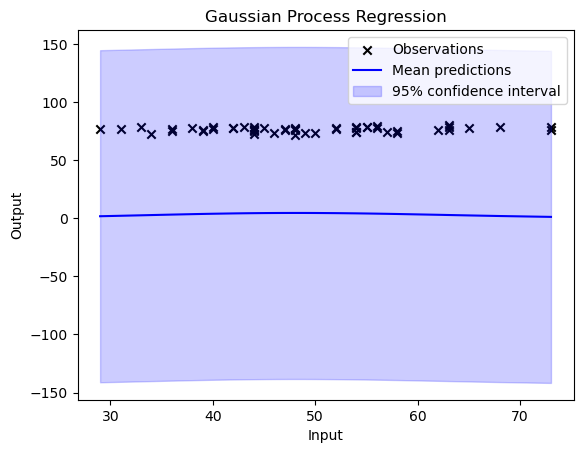

In [44]:
import matplotlib.pyplot as plt

# Plot observations
plt.scatter(X, y, color='k', marker='x', label='Observations')

# Plot prediction means as blue line
plt.plot(X, y_pred, color='b', label='Mean predictions')

# Plot confidence intervals as blue shaded area
plt.fill_between(X.ravel(), y_pred - 1.96 * sigma, y_pred + 1.96 * sigma, color='blue', alpha=0.2, label='95% confidence interval')

plt.xlabel('Input')
plt.ylabel('Output')
plt.title('Gaussian Process Regression')
plt.legend()
plt.show()
